# Employee Attrition Model

In [1]:
import ads
import os
import pandas as pd
import oci
import logging
import warnings

from ads.dataset.factory import DatasetFactory
from ads.automl.driver import AutoML
from ads.automl.provider import OracleAutoMLProvider

warnings.filterwarnings('ignore')
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR )


In [2]:
employees = DatasetFactory.open("orcl_attrition.csv", target="Attrition").set_positive_class('Yes')
employees.head()

INFO:ads.dataset:dd.read_csv(orcl_attrition.csv) -- assume_missing:True


Age  Attrition TravelForWork  SalaryLevel         JobFunction  \
0   42       True    infrequent         5054  Product Management   
1   50      False         often         1278  Software Developer   
2   38       True    infrequent         6296  Software Developer   
3   34      False         often         6384  Software Developer   
4   28      False    infrequent         2710  Software Developer   

   CommuteLength EducationalLevel EducationField  Directs  EmployeeNumber  \
0              2               L2  Life Sciences        1               1   
1              9               L1  Life Sciences        1               2   
2              3               L2          Other        1               4   
3              4               L4  Life Sciences        1               5   
4              3               L1        Medical        1               7   

   ...  WeeklyWorkedHours StockOptionLevel  YearsinIndustry  \
0  ...                 80                0                8   
1  ...                 80                1               10   
2  ...                 80                0                7   
3  ...                 80                0                8   
4  ...                 80                1                6   

   TrainingTimesLastYear  WorkLifeBalance YearsOnJob  YearsAtCurrentLevel  \
0                      0                1          6                    4   
1                      3                3         10                    7   
2                      3                3          0                    0   
3                      3                3          8                    7   
4                      3                3          2                    2   

  YearsSinceLastPromotion  YearsWithCurrManager               name  
0                       0                     5        Tracy Moore  
1                       1                     7      Andrew Hoover  
2                       0                     0         Julie Bell  
3                       3                     0       Thomas Adams  
4                       2                     2  Johnathan Burnett  

[5 rows x 36 columns]

In [3]:
#employees.show_in_notebook()

In [4]:
#employees.show_corr()

In [5]:
employees.get_recommendations()

INFO:ads.dataset:Dropping columns {'WeeklyWorkedHours', 'Directs', 'EmployeeNumber', 'Over18'}
Column 'Directs' is constant and will be dropped
Column 'Over18' is constant and will be dropped
Column 'WeeklyWorkedHours' is constant and will be dropped


Output()

In [6]:
ds = employees

In [7]:
ds.suggest_recommendations()

INFO:ads.dataset:Dropping columns {'WeeklyWorkedHours', 'Directs', 'EmployeeNumber', 'Over18'}


Code
Message                                  Variables         Suggested              Action                                                      
Constant Column                          Directs           Drop                   Drop                              .drop_columns(["Directs"])
                                         Over18            Drop                   Drop                               .drop_columns(["Over18"])
                                         WeeklyWorkedHours Drop                   Drop                    .drop_columns(["WeeklyWorkedHours"])
Contains mostly unique values(100.00%)   EmployeeNumber    Drop                   Drop                       .drop_columns(["EmployeeNumber"])
                                                                                  Do nothing                                                  
Strongly correlated with PerformanceR... PercentSalaryHike Drop PerformanceRating Drop PercentSalaryHike  .drop_columns(["PercentSalaryHike"])
                                                                                  Drop PerformanceRating  .drop_columns(["PerformanceRating"])
                                                                                  Do nothing                                                  
Strongly correlated with name(99.60%.)   MonthlyIncome     Drop name              Drop MonthlyIncome          .drop_columns(["MonthlyIncome"])
                                                                                  Drop name                            .drop_columns(["name"])
                                                                                  Do nothing                                                  
Strongly correlated with name(99.31%.)   MonthlyRate       Drop MonthlyRate       Drop MonthlyRate              .drop_columns(["MonthlyRate"])
                                                                                  Drop name                            .drop_columns(["name"])
                                                                                  Do nothing                                                  
Strongly correlated with name(99.54%.)   SalaryLevel       Drop name              Drop SalaryLevel              .drop_columns(["SalaryLevel"])
                                                                                  Drop name                            .drop_columns(["name"])
                                                                                  Do nothing                                                  
Imbalanced Target(19.22%)                Attrition         Do nothing             Do nothing                                                  
                                                                                  Down-sample                                   .down_sample()
                                                                                  Up-sample                      .up_sample(sampler='default')

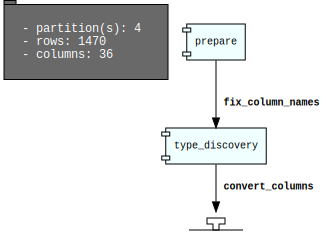

INFO:ads.dataset:Dropping columns {'WeeklyWorkedHours', 'Directs', 'EmployeeNumber', 'Over18'}
INFO:ads.dataset:Drop constant columns:
['Directs', 'Over18',
'WeeklyWorkedHours']
INFO:ads.dataset:Drop: "EmployeeNumber"
INFO:ads.dataset:Drop: "PerformanceRating"
INFO:ads.dataset:Drop: "name"
INFO:ads.dataset:Drop: "MonthlyRate"
INFO:ads.dataset:Drop: "name"
INFO:ads.dataset:Dropping columns {'WeeklyWorkedHours', 'MonthlyRate', 'Directs', 'name', 'EmployeeNumber', 'Over18', 'PerformanceRating'}
INFO:ads.dataset:Dropping columns {'WeeklyWorkedHours', 'MonthlyRate', 'Directs', 'name', 'EmployeeNumber', 'Over18', 'PerformanceRating'}


In [8]:
ds.visualize_transforms()
transformed_ds = ds.auto_transform(fix_imbalance=False)


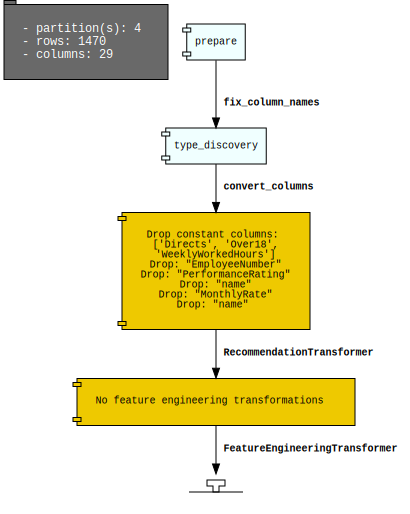

In [9]:
transformed_ds.visualize_transforms()

In [10]:
train, test = transformed_ds.train_test_split()
automl = AutoML(train, provider=OracleAutoMLProvider())


INFO:ads.automl.provider:Running on 96174e7f0f27 4 logical cores
INFO:ads.automl.provider.xengine:dask xengine initialization: <Client: 'inproc://10.0.1.42/21138/1' processes=1 threads=4, memory=28.12 GB>


In [11]:
model, baseline = automl.train(model_list=
                               ["LogisticRegression", 
                                "LGBMClassifier", 
                                "XGBClassifier", 
                                "RandomForestClassifier"],  min_features=["OverTime", "JobLevel"], score_metric="roc_auc", time_budget=160 )

INFO:ads.automl.provider.interface:Inferred col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


In [12]:
from sklearn.metrics import get_scorer
accuracy_scorer = get_scorer("accuracy")
print("Accuracy of model : " , model.score(test.X, test.y, score_fn=accuracy_scorer) )

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


In [13]:
from ads.common.model import ADSModel


In [14]:
model.selected_model_params_

{'C': 47.00427550259388,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': 2,
 'penalty': 'l2',
 'random_state': 7,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
model.ranked_models_

['LogisticRegression']

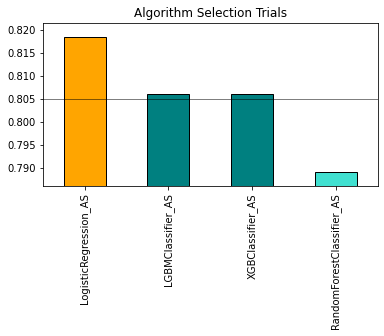

In [16]:
automl.visualize_algorithm_selection_trials()

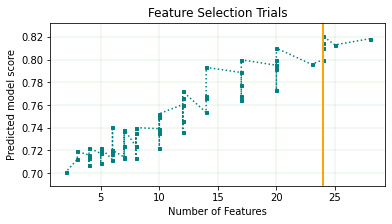

In [17]:
automl.visualize_feature_selection_trials()

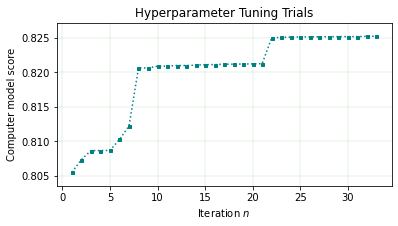

In [18]:
automl.visualize_tuning_trials()

# ADS Support Models from other sources

In [19]:
%%writefile dataframelabelencoder.py

from collections import defaultdict
from category_encoders.ordinal import OrdinalEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin

class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
    
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name in ('category', 'object'):
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X
    

    

Overwriting dataframelabelencoder.py


In [20]:
from dataframelabelencoder import DataFrameLabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X = le.fit_transform(X)

sk_clf = RandomForestClassifier(random_state=42)
sk_clf.fit(X,y)

sk_model = make_pipeline(le, sk_clf)
my_model = ADSModel.from_estimator(sk_model, name=sk_clf.__class__.__name__)


In [21]:
print("Accuracy of sk model :" , my_model.score(test.X, test.y, score_fn=accuracy_scorer))

Accuracy of sk model : 0.86


# Evaluate Model using ADSEvaluator

In [22]:
from ads.evaluations.evaluator import ADSEvaluator

evaluator = ADSEvaluator(test, models=[model, my_model, baseline], training_data=train)

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


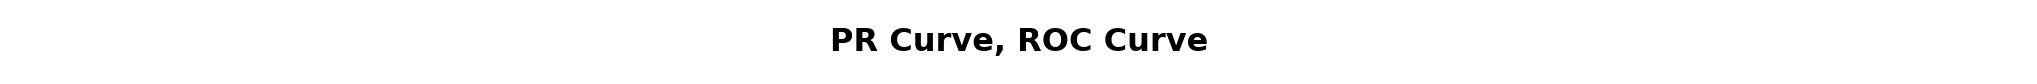

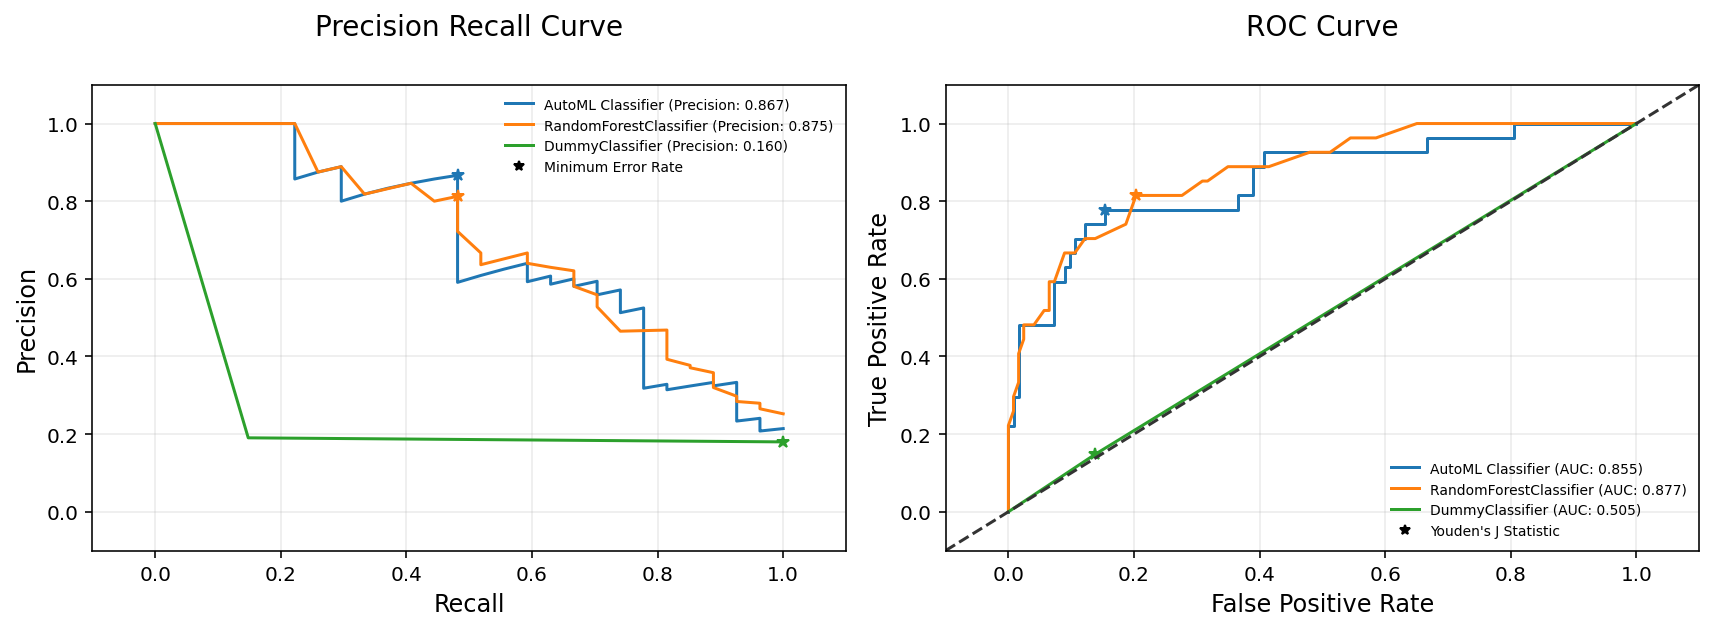

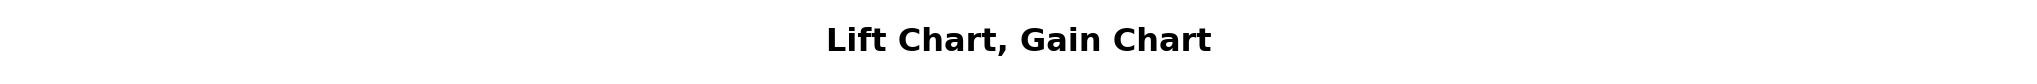

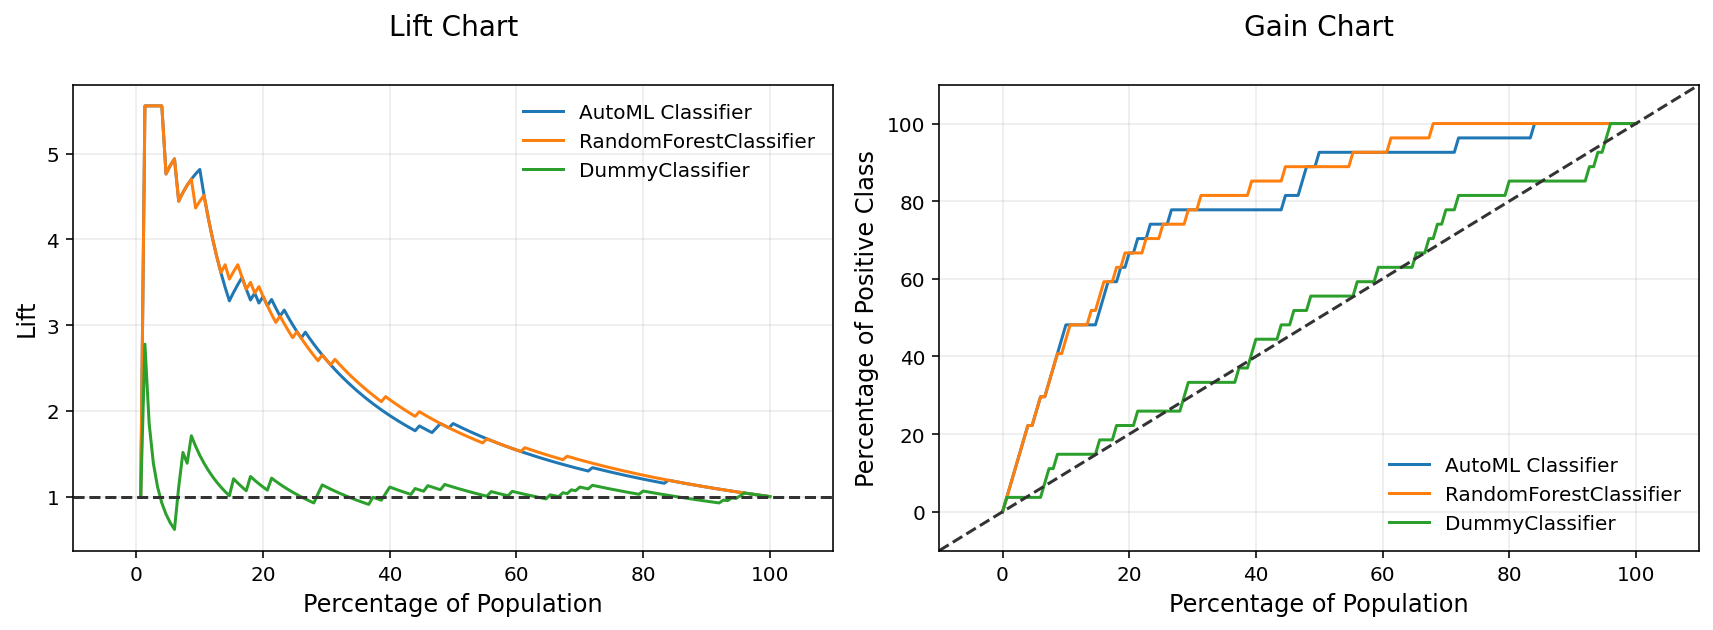

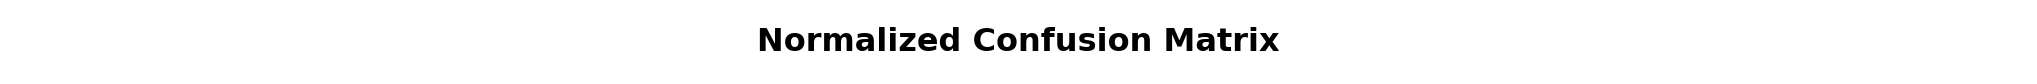

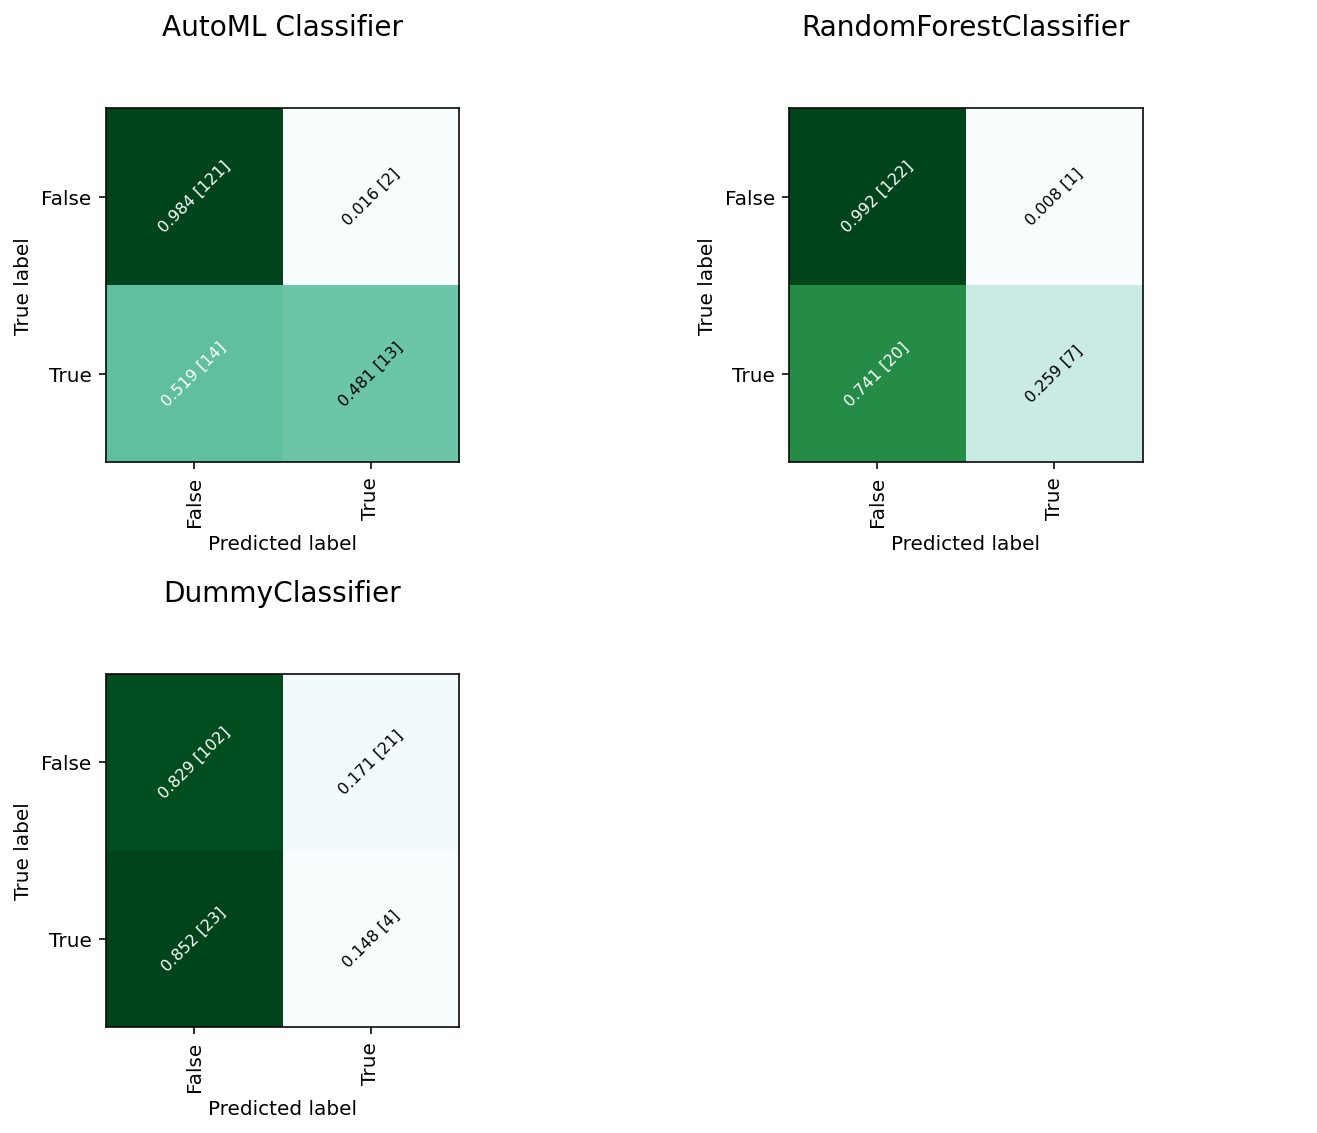

In [23]:
evaluator.show_in_notebook()

In [24]:
evaluator.calculate_cost(tn_weight=1, tp_weight=1, fp_weight=1, fn_weight=1)

model  cost
0       AutoML Classifier   150
1  RandomForestClassifier   150
2         DummyClassifier   150

In [25]:
evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_548e89fe_bcfc_11ed_ab89_0242ac130002  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_5494134c_bcfc_11ed_ab89_0242ac130002  {\n          text-align: r…

# MLX

In [26]:
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_whatif_explainer import MLXWhatIfExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer


In [27]:
explainer = ADSExplainer(test, model)

In [28]:
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())
whatif_explainer = explainer.whatif_explanation(provider=MLXWhatIfExplainer())

In [29]:
importances = global_explainer.compute_feature_importance()
importances.show_in_notebook()

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


In [30]:
whatif_explainer.explore_sample(row_idx=0)

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


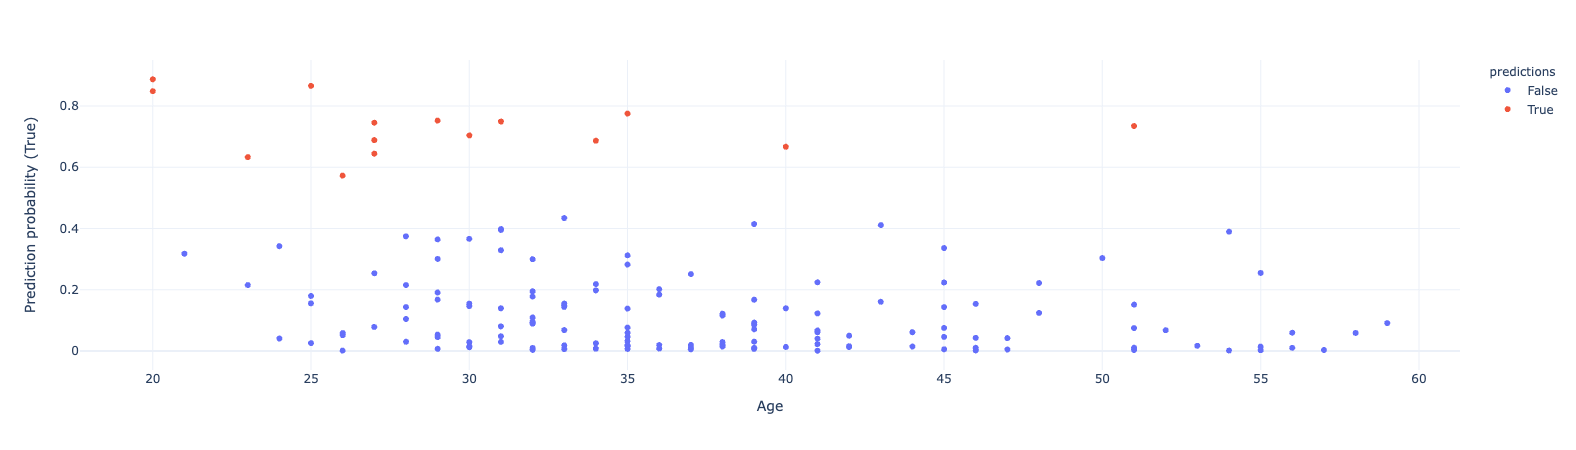

In [31]:
whatif_explainer.explore_predictions('Age')

In [32]:
explanation = global_explainer.compute_partial_dependence('OverTime')
explanation.show_in_notebook(mode='pdp')

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


In [33]:
explanation.show_in_notebook(mode='ice')

In [34]:
local_explainer = explainer.local_explanation(provider=MLXLocalExplainer())
(X,y) = test.X.iloc[0:1], test.y.iloc[0:1]

In [35]:
local_explainer.explain(X,y).show_in_notebook()

INFO:ads.automl.provider.interface:Provided col_types: [('Age', 'numerical'), ('TravelForWork', 'categorical'), ('SalaryLevel', 'numerical'), ('JobFunction', 'categorical'), ('CommuteLength', 'numerical'), ('EducationalLevel', 'categorical'), ('EducationField', 'categorical'), ('EnvironmentSatisfaction', 'numerical'), ('Gender', 'categorical'), ('HourlyRate', 'numerical'), ('JobInvolvement', 'numerical'), ('JobLevel', 'numerical'), ('JobRole', 'categorical'), ('JobSatisfaction', 'numerical'), ('MaritalStatus', 'categorical'), ('MonthlyIncome', 'numerical'), ('NumCompaniesWorked', 'numerical'), ('OverTime', 'categorical'), ('PercentSalaryHike', 'numerical'), ('RelationshipSatisfaction', 'numerical'), ('StockOptionLevel', 'numerical'), ('YearsinIndustry', 'numerical'), ('TrainingTimesLastYear', 'numerical'), ('WorkLifeBalance', 'numerical'), ('YearsOnJob', 'numerical'), ('YearsAtCurrentLevel', 'numerical'), ('YearsSinceLastPromotion', 'numerical'), ('YearsWithCurrManager', 'numerical')]


# Saving model to model catalog

In [42]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import joblib

In [43]:
sklearn_path = "./model-artifact"

sklearn_artifact = prepare_generic_model(sklearn_path, function_artifacts=False, data_science_env=True,  force_overwrite=True)

joblib.dump(sk_model, os.path.join(sklearn_path, "model.joblib"))

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


['./model-artifact/model.joblib']

In [58]:
encoder_path = os.path.join(sklearn_path, "dataframelabelencoder.py")
score_path = os.path.join(sklearn_path, "score.py")
!cp dataframelabelencoder.py {encoder_path}

In [63]:
%%writefile {score_path}
import json
import io
import os
from joblib import load
import pandas as pd

from dataframelabelencoder import DataFrameLabelEncoder

def load_model():
    model_dir = os.path.dirname(os.path.relpath(__file__))
    contents = os.listdir(model_dir)
    model_file = "model.joblib"
    if model_file in contents:
        with open(os.path.join(model_dir, model_file), "rb") as file:
            model = load(file)
    else:
        raise Exception("{0} is not found in {1} directory".format(model_file, model_dir))
    return model

def predict(data, model=load_model()):
    assert model is not None, "model not loaded"
    X = pd.read_json(io.StringIO(data) if isinstance(data, str) else pd.DataFrame.from_dict(data) )
    preds = model.predict(X).tolist()
    return {"prediction": preds}

Overwriting ./model-artifact/score.py


# Test the model

In [64]:
input_data = train.X[:5].to_json()

In [68]:
import sys
import numpy as np
import os 

sys.path.insert(0, sklearn_path)

from score import load_model, predict

_ = load_model()


predictions_test = np.asarray(predict(train.X[:5].to_json(), _)["prediction"])
predictions = _.predict( train.X[:5])

In [69]:
predictions_test

array([ True, False,  True, False, False])

In [70]:
predictions

array([ True, False,  True, False, False])